In [12]:
library(Seurat)

In [13]:
scRNA = readRDS('./after_rename.rds')

In [14]:
DefaultAssay(scRNA)  = 'RNA'
Idents(scRNA) = 'orig.ident'
object.markers <- FindMarkers(scRNA, ident.1 = 'MI3d',ident.2 = 'control',only.pos = T)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = rownames(object.markers), fromType = "SYMBOL", :
“3.86% of input gene IDs are fail to map...”
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
“Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version.”
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
“Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version.”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


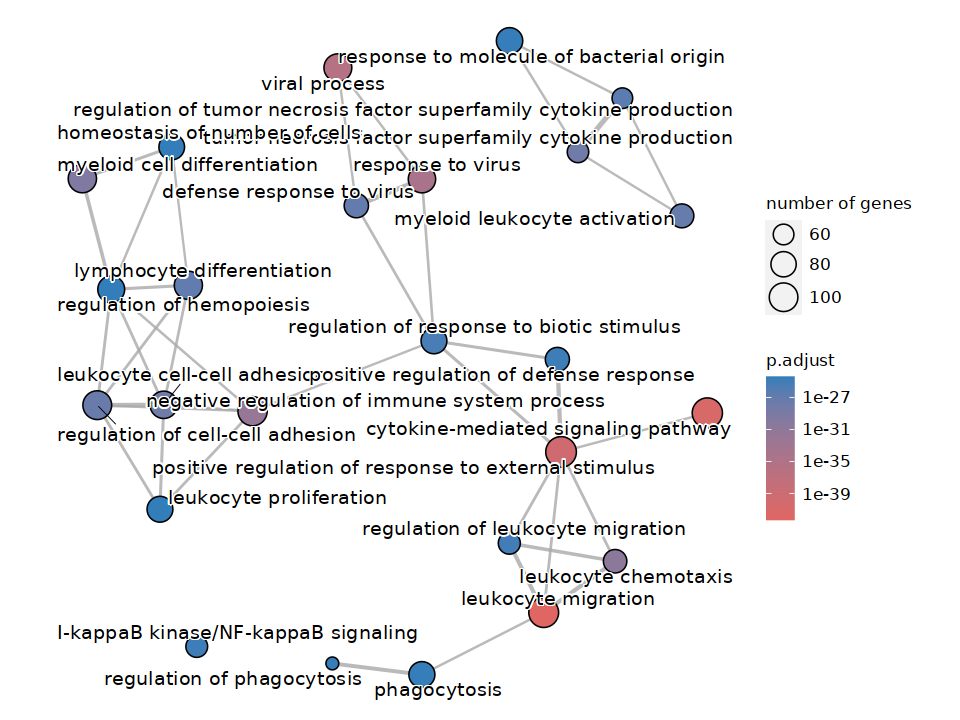

In [15]:
library(clusterProfiler)
library(org.Mm.eg.db)

gene_symbol <- bitr(geneID = rownames(object.markers),  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")

gene <- gene_symbol[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "BP",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #

write.csv(CC@result,file = 'MI3dvscontrol_up_gene_GO.csv')

options(repr.plot.height = 6,repr.plot.width = 8)

bp <-clusterProfiler::simplify(CC)

BP_ego <- enrichplot::pairwise_termsim(bp)

emapplot(BP_ego, cex_label_category=.8, cex_line=.5,showCategory = 25) + 
  ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                        guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10') 

In [17]:
ggsave('1.pdf',width = 8,height = 8)

### gsea

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster3.markers$gene, "SYMBOL", "ENTREZID", "org.Mm.eg.db"):
“4.1% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



[1] 3813

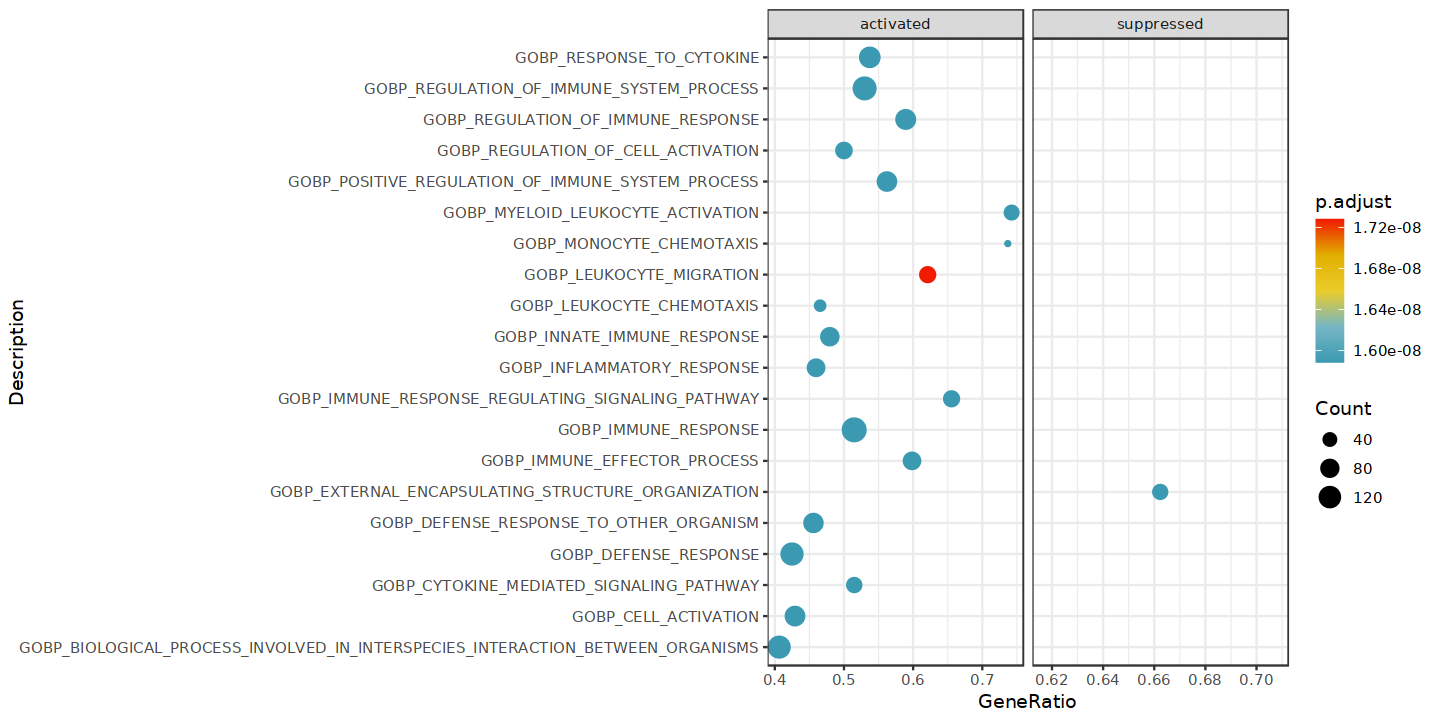

In [18]:
cluster3.markers <- FindMarkers(scRNA, ident.1 = 'MI3d', ident.2 = 'control', min.pct = 0.25)

library(clusterProfiler)
library(enrichplot)
library(org.Mm.eg.db)
#为每个基因添加对应的ENTREZID
cluster3.markers$gene <- rownames(cluster3.markers)
ids=bitr(cluster3.markers$gene,'SYMBOL','ENTREZID','org.Mm.eg.db')                                 
#合并数据，cluser3.markers中没有ENTREZID的基因将被过虑掉
cluster3.markers=merge(cluster3.markers,ids,by.x='gene',by.y='SYMBOL')

cluster3.markers <- cluster3.markers[order(cluster3.markers$avg_log2FC,decreasing = T),]
#生成仅含有ENTREZID名字和avg_log2FC值的gene list
cluster3.markers_list <- as.numeric(cluster3.markers$avg_log2FC)
names(cluster3.markers_list) <- cluster3.markers$gene

  library(fgsea)          
  library(data.table)    
  library(ggplot2)        
  library(dplyr)         
  library(msigdb)         
  library(GSEABase)
  library(msigdbr)
library(tidyr)

 m_t2g <- msigdbr(species = "Mus musculus", category = "C5") %>% 
    dplyr::select(gs_name, gene_symbol)
                                                                    
  gsea_res <- GSEA(cluster3.markers_list, 
                   TERM2GENE = m_t2g,
                   minGSSize = 10,
                   maxGSSize = 500,
                   pvalueCutoff = 1,
                   pAdjustMethod = "BH")

g1 = gsea_res@result

num<-g1[,c(1,11)]

num<-num%>% separate_rows(core_enrichment, sep = "/")%>%group_by(ID)%>%count()
num<-num[match(g1$ID,num$ID),]
sum(num$ID==g1$ID)
g1$Count<-num$n

data<-g1%>%mutate(GeneRatio = Count/setSize)
data$sign<-ifelse(data$NES>0,"activated","suppressed")

library(stringr)

data  %>%  filter(grepl('BP', Description)) %>% head(.,20) -> data1

options(repr.plot.height = 6,repr.plot.width = 12)

library(RColorBrewer)
library(wesanderson)
ggplot(data1)+geom_point(aes(x=GeneRatio ,y=Description,colour=p.adjust,size=Count))+
facet_grid(~sign,scales = "free") +scale_colour_gradientn(colors=wes_palette("Zissou1",80,type="continuous"))+
theme_bw()


In [19]:
ggsave('1-1.pdf',width = 6,height = 12)

### 14d vs 3d

In [20]:
DefaultAssay(scRNA)  = 'RNA'
Idents(scRNA) = 'orig.ident'
object.markers2 <- FindMarkers(scRNA, ident.1 = 'MI3d',ident.2 = 'MI14d',only.pos = T)

In [21]:
#object.markers2 = object.markers2 %>% filter(avg_log2FC > 0.8 & p_val_adj < 0.01)

In [22]:
library(clusterProfiler)
library(org.Mm.eg.db)

gene_symbol <- bitr(geneID = rownames(object.markers2),  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")

gene <- gene_symbol[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "BP",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #

#write.csv(CC@result,file = 'MI3dvscontrol_up_gene_GO.csv')

options(repr.plot.height = 6,repr.plot.width = 8)

bp <-clusterProfiler::simplify(CC)

BP_ego <- enrichplot::pairwise_termsim(bp)



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = rownames(object.markers2), fromType = "SYMBOL", :
“4.17% of input gene IDs are fail to map...”


Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
“Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version.”
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
“Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version.”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


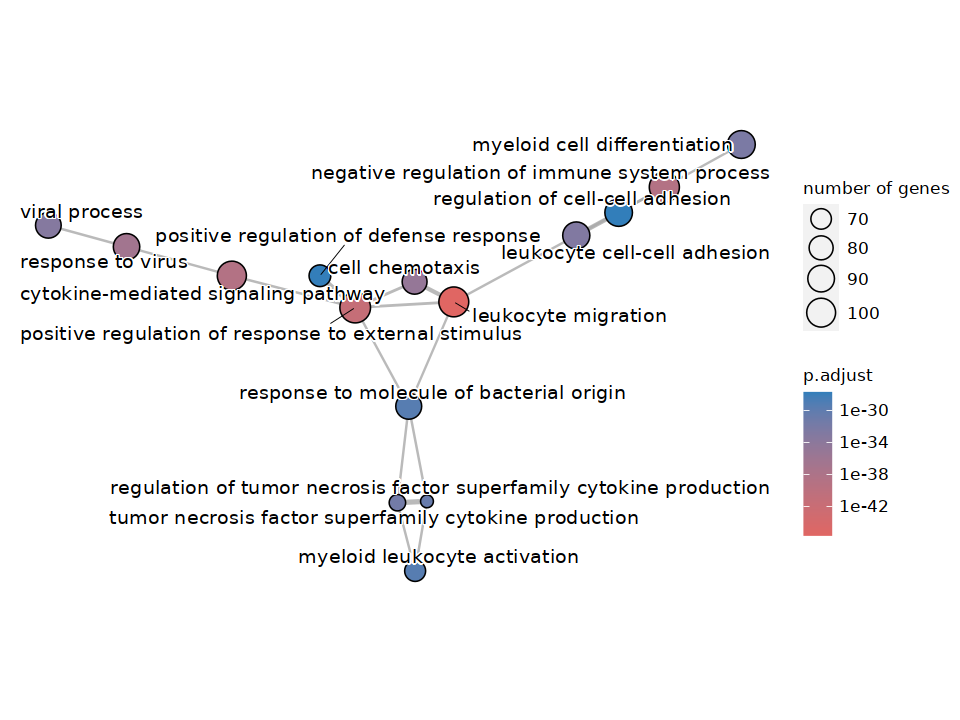

In [23]:
emapplot(BP_ego, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
  ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                        guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10') 

In [24]:
ggsave('2.pdf',width = 8,height = 8)

### gsea

In [25]:
cluster3.markers <- FindMarkers(scRNA, ident.1 = 'MI14d', ident.2 = 'MI3d', min.pct = 0.25)

library(clusterProfiler)
library(enrichplot)
library(org.Mm.eg.db)
#为每个基因添加对应的ENTREZID
cluster3.markers$gene <- rownames(cluster3.markers)
ids=bitr(cluster3.markers$gene,'SYMBOL','ENTREZID','org.Mm.eg.db')
#合并数据，cluser3.markers中没有ENTREZID的基因将被过虑掉
cluster3.markers=merge(cluster3.markers,ids,by.x='gene',by.y='SYMBOL')

cluster3.markers <- cluster3.markers[order(cluster3.markers$avg_log2FC,decreasing = T),]
#生成仅含有ENTREZID名字和avg_log2FC值的gene list
cluster3.markers_list <- as.numeric(cluster3.markers$avg_log2FC)
names(cluster3.markers_list) <- cluster3.markers$gene

  library(fgsea)          
  library(data.table)    
  library(ggplot2)        
  library(dplyr)         
  library(msigdb)         
  library(GSEABase)
  library(msigdbr)
library(tidyr)

 m_t2g <- msigdbr(species = "Mus musculus", category = "C5") %>% 
    dplyr::select(gs_name, gene_symbol)
  
  gsea_res <- GSEA(cluster3.markers_list, 
                   TERM2GENE = m_t2g,
                   minGSSize = 10,
                   maxGSSize = 500,
                   pvalueCutoff = 1,
                   pAdjustMethod = "BH")



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(cluster3.markers$gene, "SYMBOL", "ENTREZID", "org.Mm.eg.db"):
“4.13% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



[1] 3810

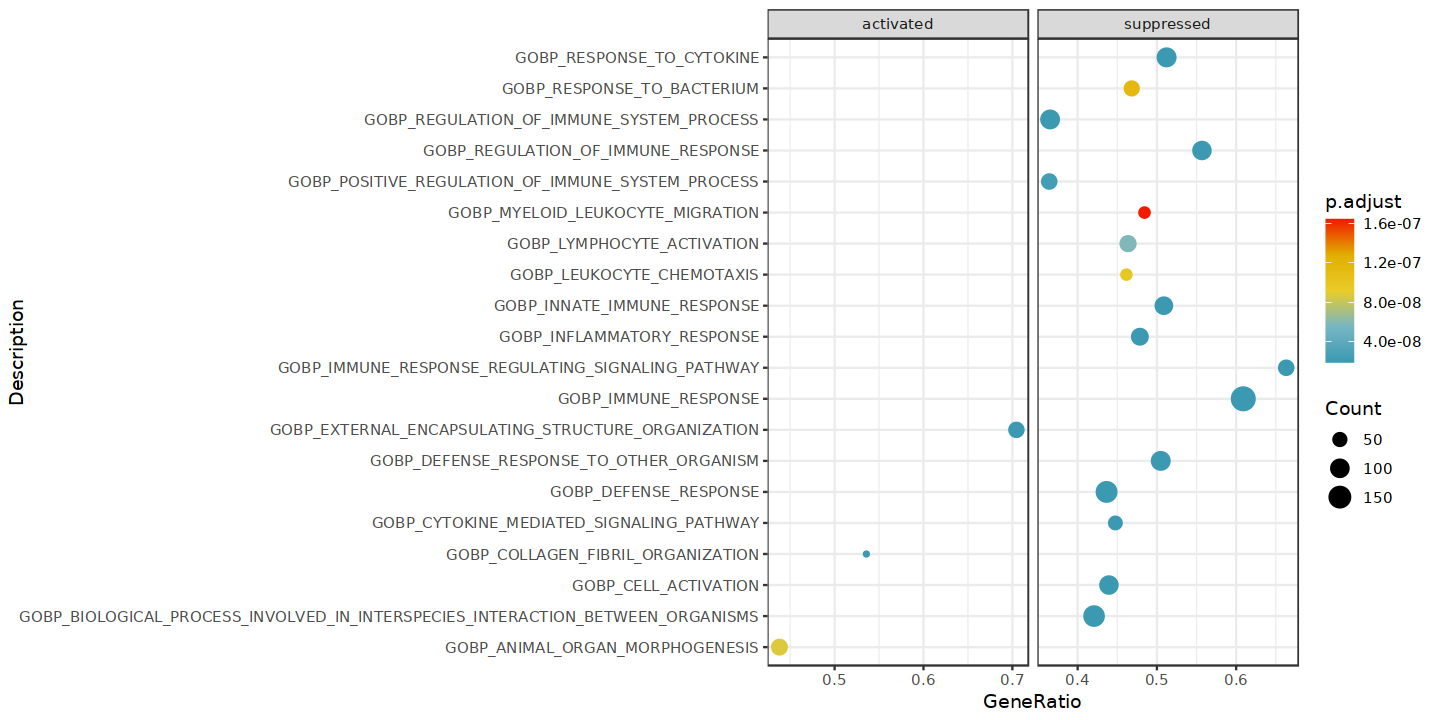

In [26]:
g1 = gsea_res@result

num<-g1[,c(1,11)]

num<-num%>% separate_rows(core_enrichment, sep = "/")%>%group_by(ID)%>%count()
num<-num[match(g1$ID,num$ID),]
sum(num$ID==g1$ID)
g1$Count<-num$n

data<-g1%>%mutate(GeneRatio = Count/setSize)
data$sign<-ifelse(data$NES>0,"activated","suppressed")

library(stringr)

data  %>%  filter(grepl('BP', Description)) %>% head(.,20) -> data1

options(repr.plot.height = 6,repr.plot.width = 12)

library(RColorBrewer)
library(wesanderson)
ggplot(data1)+geom_point(aes(x=GeneRatio ,y=Description,colour=p.adjust,size=Count))+
facet_grid(~sign,scales = "free") +scale_colour_gradientn(colors=wes_palette("Zissou1",80,type="continuous"))+
theme_bw()

In [27]:
ggsave('2-2.pdf',width = 6,height = 12)

In [35]:
gene_symbol <- bitr(geneID = rownames(object.markers2),  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型aa
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = rownames(object.markers2), fromType = "SYMBOL", :
“3.78% of input gene IDs are fail to map...”


In [36]:
gene <- gene_symbol[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "ALL",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #

In [37]:
write.csv(CC@result,file = 'MI3dvsMI14d_up_gene_GO.csv')

In [65]:
options(repr.plot.height = 11,repr.plot.width = 7)

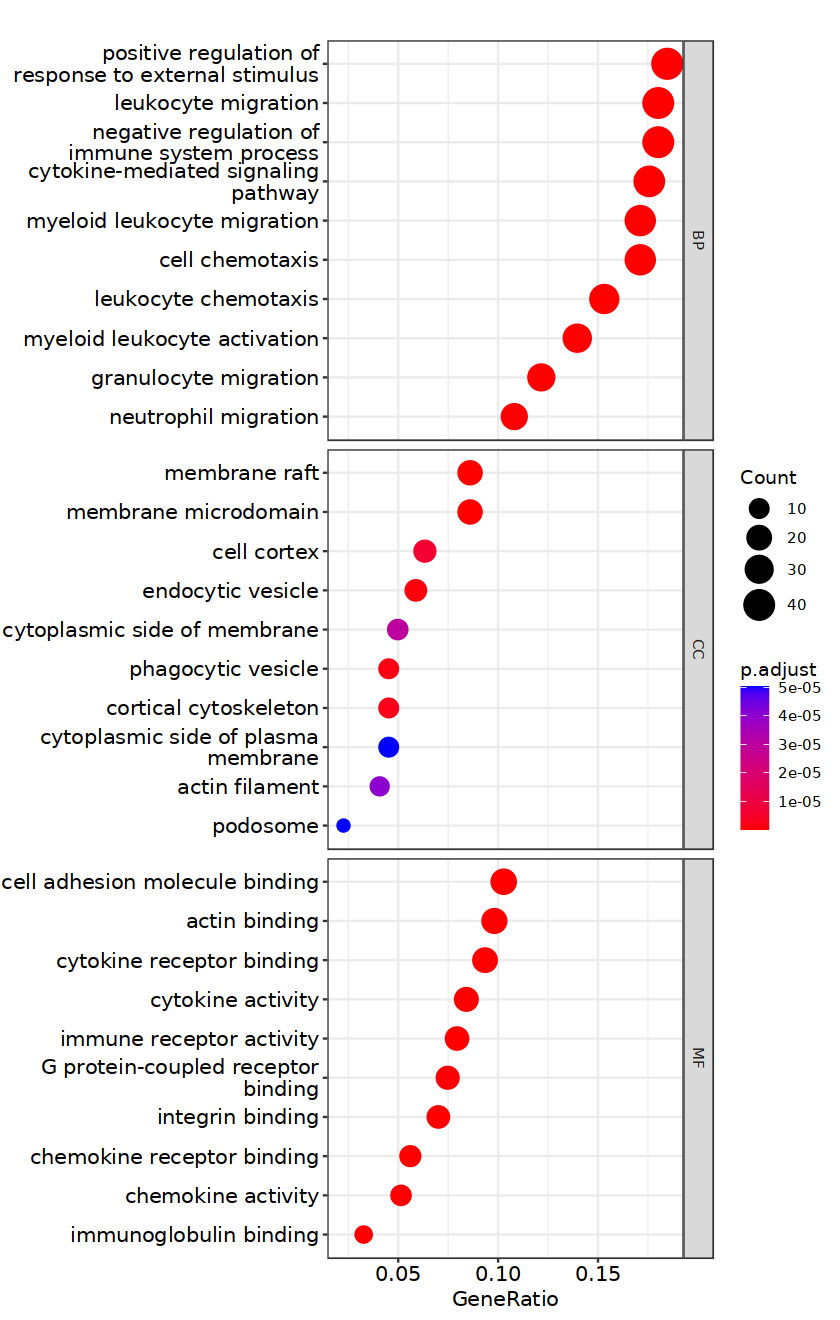

In [66]:
dotplot(CC, split="ONTOLOGY")+facet_grid(ONTOLOGY~., scale="free")

### 取交集

In [51]:
inter = data.frame(intersect(rownames(object.markers),rownames(object.markers2)))

In [52]:
colnames(inter) = 'genename'

In [53]:
write.table(inter,file = 'overlap.gene.txt',quote = F,row.names = F)

In [55]:
gene_symbol <- bitr(geneID = inter$genename,  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = inter$genename, fromType = "SYMBOL", toType = c("ENTREZID"), :
“3.45% of input gene IDs are fail to map...”


In [56]:
gene <- gene_symbol[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "ALL",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 10,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #

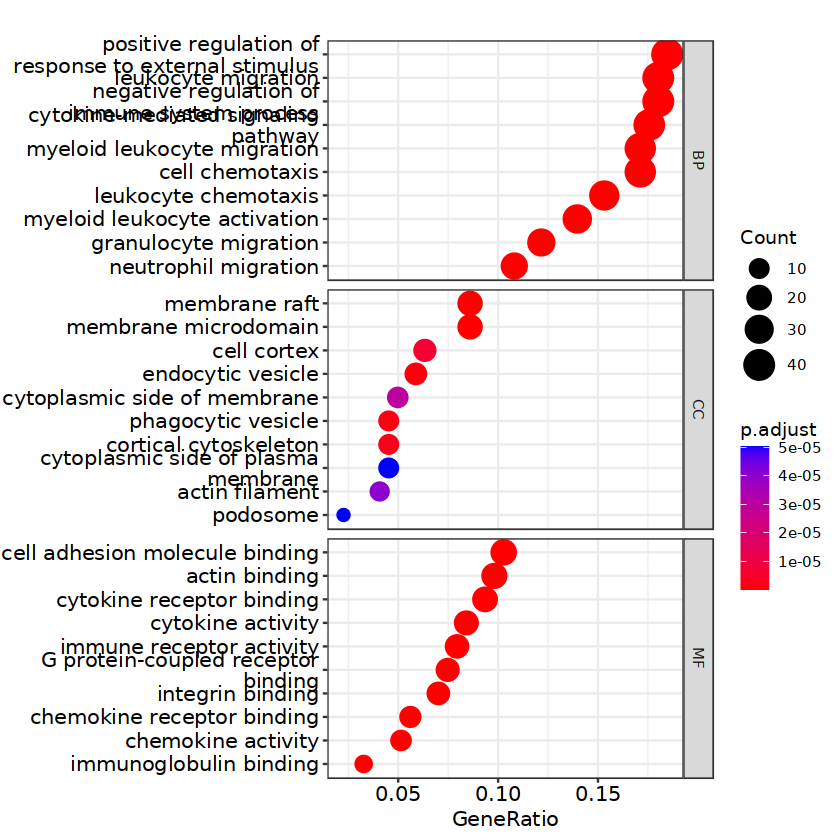

In [57]:
dotplot(CC, split="ONTOLOGY")+facet_grid(ONTOLOGY~., scale="free")

In [58]:
write.csv(CC@result,file = 'overlap_GO.csv')

In [ ]:
DefaultAssay(scRNA)  = 'RNA'

Idents(scRNA) = 'orig.ident'

object.markers <- FindMarkers(scRNA, ident.1 = 'MI3d',ident.2 = 'control')

object.markers_1 = object.markers
dim(object.markers)
object.markers = object.markers_1
object.markers$names <- rownames(object.markers)
library(ggplot2)

library(dplyr)
object.markers <- object.markers %>% filter(p_val_adj < 0.05)%>% mutate(Difference = pct.1 - pct.2)
library(ggrepel)
head(object.markers,2)
object.markers$group=0
for (i in 1:nrow(object.markers)){
  if (object.markers$avg_log2FC[i] >= 1 & object.markers$Difference[i] >= 0.2 ){
    object.markers$group[i]='up'
  }
  else if(object.markers$avg_log2FC[i] <= -1 & object.markers$Difference[i] <= -0.2 ){
    object.markers$group[i]='down'
  }
  else {
    object.markers$group[i]='no'
  }
}
dim(object.markers)
table(object.markers$group)
top_25<- bind_rows(   #分别筛选差异显著前10个的上下调基因，并合并两组数值进行绘图
  object.markers %>%
    filter(group == 'up') %>%
    arrange(desc(avg_log2FC), abs(Difference)) %>%
    head(25),
  object.markers %>%
    filter(group == 'down') %>%
    arrange(avg_log2FC, desc(abs(Difference))) %>%
    head(25)
)
#library(gt)
#top_25 %>% gt()  #将数据制成表

p1= ggplot(object.markers, aes(x=Difference, y=avg_log2FC)) + 
geom_point(size=0.2,aes(color=group),alpha = 0.5)  + 
  # geom_label_repel(data=subset(object.markers, avg_log2FC >= 1 & Difference >= 0.2 & pct.2 <= 0.05), aes(label=names), label.padding = 0.1, fill="tomato2", segment.size = 0.25, size=2.5)+
  theme_classic()
#绘图——添加基因标签框图#
 p4 <- p1 +
  geom_label_repel(data = top_25,max.overlaps = 50,
                   aes(label = names),
                   size = 3,
    box.padding = unit(0.5, "lines"),
    point.padding = unit(0.8, "lines"), segment.color = "black", show.legend = FALSE ) +xlim(-0.8,.8)  + 
  scale_color_manual(values=c('blue','grey','red'))+ geom_vline(xintercept = 0.0,linetype=2)+
  geom_hline(yintercept = 0,linetype=2)+
  theme_classic()+ggtitle('Ang_Veh')
p4